# 📚 **Install & Import Libraries**

In [10]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.3 MB/s eta 0:00:00


In [13]:
!pip install hyperopt

In [17]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.3 MB/s eta 0:00:00


In [33]:
!pip install hpbandster-sklearn

In [37]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


In [38]:
# Import necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from skopt import BayesSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from deap import base, creator, tools, algorithms
import random
from hpbandster_sklearn import HpBandSterSearchCV
import optuna

In [4]:
# Load the Iris dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVM classifier
svm = SVC()

# **1. Grid Search**

In [5]:
# Define the hyperparameters to tune and their possible values
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
best_svm = grid_search.best_estimator_
accuracy = best_svm.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'C': 1, 'gamma': 1}
Accuracy on Test Set: 1.0


# **2. Random Search**

In [7]:
# Define the hyperparameters and their search spaces
param_dist = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

# Use RandomizedSearchCV for Random Search
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters from Random Search
print("Best Hyperparameters (Random Search):", random_search.best_params_)

# Evaluate the models with the best hyperparameters on the test set
best_svm_random = random_search.best_estimator_
accuracy_random = best_svm_random.score(X_test, y_test)
print("Accuracy on Test Set (Random Search):", accuracy_random)

Best Hyperparameters (Random Search): {'gamma': 0.1, 'C': 1}
Accuracy on Test Set (Random Search): 1.0


# **3. Bayesian Optimization**

In [12]:
# Define the hyperparameters and their search spaces
param_dist = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

# Use BayesSearchCV for Bayesian Optimization
bayesian_opt = BayesSearchCV(svm, search_spaces={'C': (0.1, 100), 'gamma': (0.01, 10)}, n_iter=10, cv=5)
bayesian_opt.fit(X_train, y_train)

# Print the best hyperparameters from Bayesian Optimization
print("Best Hyperparameters (Bayesian Optimization):", bayesian_opt.best_params_)

best_svm_bayesian = bayesian_opt.best_estimator_
accuracy_bayesian = best_svm_bayesian.score(X_test, y_test)
print("Accuracy on Test Set (Bayesian Optimization):", accuracy_bayesian)

Best Hyperparameters (Bayesian Optimization): OrderedDict([('C', 86.43262829720466), ('gamma', 2.039010901369773)])
Accuracy on Test Set (Bayesian Optimization): 1.0


# **4. Gradient-Based Optimization / Tree-structured Parzen Estimators (TPE)**

In [16]:
# Define objective function to minimize (negative accuracy)
def objective(params):
    clf = SVC(C=params['C'], gamma=params['gamma'])
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define search space for hyperparameters
space = {'C': hp.loguniform('C', -3, 2), 'gamma': hp.loguniform('gamma', -3, 2)}

# Perform optimization using Tree of Parzen Estimators (TPE)
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Print the best hyperparameters
print("Best Hyperparameters (Gradient-Based Optimization):", best)

# Evaluate the model with the best hyperparameters on the test set
best_svm_gradient = SVC(C=best['C'], gamma=best['gamma'])
best_svm_gradient.fit(X_train, y_train)
accuracy_gradient = best_svm_gradient.score(X_test, y_test)
print("Accuracy on Test Set (Gradient-Based Optimization):", accuracy_gradient)

100%|██████████| 10/10 [00:00<00:00, 68.97trial/s, best loss: -0.9583333333333334]
Best Hyperparameters (Gradient-Based Optimization): {'C': 0.8192182137468389, 'gamma': 0.9243140186047749}
Accuracy on Test Set (Gradient-Based Optimization): 1.0


# **5. Genetic Algorithms**

In [30]:
# Define objective function to maximize (accuracy)
def objective_model(params):
    # The 'gamma' parameter of SVC must be a str among {'scale', 'auto'} or a float in the range [0.0, inf)
    clf = SVC(C=max(0.1, params[0]), gamma=params[1])
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return score,

# Define genetic algorithm parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.1, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", objective_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Perform genetic algorithm optimization
population = toolbox.population(n=10)
algorithms.eaMuPlusLambda(population, toolbox, mu=10, lambda_=50, cxpb=0.7, mutpb=0.2, ngen=10, stats=None, halloffame=None, verbose=True)

# Print the best individual's hyperparameters
best_individual = tools.selBest(population, k=1)[0]
print("Best Hyperparameters (Genetic Algorithm):", best_individual)

# Evaluate the model with the best hyperparameters on the test set
best_svm_genetic = SVC(C=best_individual[0], gamma=best_individual[1])
best_svm_genetic.fit(X_train, y_train)
accuracy_genetic = best_svm_genetic.score(X_test, y_test)
print("Accuracy on Test Set (Genetic Algorithm):", accuracy_genetic)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	10    
1  	46    
2  	43    
3  	44    
4  	42    
5  	44    
6  	44    
7  	44    
8  	48    
9  	43    
10 	50    
Best Hyperparameters (Genetic Algorithm): [3.97166904498928, 7.492085209589785]
Accuracy on Test Set (Genetic Algorithm): 1.0


# **6. Hyperband**

In [36]:
# Define the hyperparameters to tune and their possible values
space = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

# Use GridSearchCV to find the best hyperparameters
hb_search = HpBandSterSearchCV(svm, space, cv=5, random_state=0, n_jobs=1, n_iter=10, verbose=1, optimizer = 'hyperband')
hb_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", hb_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
best_svm = SVC(C=hb_search.best_params_['C'], gamma=hb_search.best_params_['gamma'])
accuracy = hb_search.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy)

WORKER: start listening for jobs
INFO:hpbandster_sklearn.HpBandSterSearchCV:WORKER: start listening for jobs
HBMASTER: adjusted queue size to (0, 1)
INFO:hpbandster_sklearn.HpBandSterSearchCV:HBMASTER: adjusted queue size to (0, 1)
HBMASTER: starting run at 1700250044.600166
INFO:hpbandster_sklearn.HpBandSterSearchCV:HBMASTER: starting run at 1700250044.600166
WORKER: start processing job (0, 0, 0)
INFO:hpbandster_sklearn.HpBandSterSearchCV:WORKER: start processing job (0, 0, 0)
WORKER: registered result for job (0, 0, 0) with dispatcher
INFO:hpbandster_sklearn.HpBandSterSearchCV:WORKER: registered result for job (0, 0, 0) with dispatcher
WORKER: start processing job (0, 0, 1)
INFO:hpbandster_sklearn.HpBandSterSearchCV:WORKER: start processing job (0, 0, 1)
WORKER: registered result for job (0, 0, 1) with dispatcher
INFO:hpbandster_sklearn.HpBandSterSearchCV:WORKER: registered result for job (0, 0, 1) with dispatcher
WORKER: start processing job (0, 0, 2)
INFO:hpbandster_sklearn.HpBand

Best Hyperparameters: {'C': 100, 'gamma': 0.01}
Accuracy on Test Set: 1.0


# **7. Optuna**
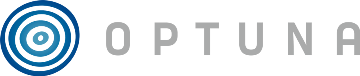

In [39]:
# Define objective function to minimize (negative accuracy)
def objective_optuna(trial):
    C = trial.suggest_loguniform('C', 0.1, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10)

    clf = SVC(C=C, gamma=gamma)
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return -score  # Negative accuracy since Optuna minimizes the objective

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective_optuna, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters (Optuna):", best_params)

# Evaluate the model with the best hyperparameters on the test set
best_svm_optuna = SVC(C=best_params['C'], gamma=best_params['gamma'])
best_svm_optuna.fit(X_train, y_train)
accuracy_optuna = best_svm_optuna.score(X_test, y_test)
print("Accuracy on Test Set (Optuna):", accuracy_optuna)

[I 2023-11-17 19:45:29,171] A new study created in memory with name: no-name-5ca55f16-037a-4928-9f43-58969b90e047
<ipython-input-39-f06d85e7428d>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100)
<ipython-input-39-f06d85e7428d>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.01, 10)
[I 2023-11-17 19:45:29,230] Trial 0 finished with value: -0.9416666666666667 and parameters: {'C': 73.66181373496023, 'gamma': 0.20768075189963264}. Best is trial 0 with value: -0.9416666666666667.
<ipython-input-39-f06d85e7428d>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fea

Best Hyperparameters (Optuna): {'C': 1.8599519901400818, 'gamma': 2.411628808928544}
Accuracy on Test Set (Optuna): 1.0
